### MSCA 31013: Big Data Platforms
### Assignment 9
#### 2/21/2021

In [1]:
print (sc.version)

3.0.1


In [2]:
from google.cloud import storage

from pyspark.sql.functions import *
from pyspark.sql.types import *

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Set-up Cloud Object Storage (COS) functions for GCS.

In [3]:
# List all files in given COS directory
def list_blobs(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    for blob in blobs:
        print(blob.name + '\t' + str(blob.size))

        
# Delete folder from COS bucket
def delete_folder(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    for blob in blobs:
        blob.delete()

In [14]:
list_blobs("msca-bdp-amazon", "amazon_reviews")

amazon_reviews/	0
amazon_reviews/amazon_reviews_us_Apparel_v1_00.tsv	1971061630
amazon_reviews/amazon_reviews_us_Automotive_v1_00.tsv	1350294084
amazon_reviews/amazon_reviews_us_Baby_v1_00.tsv	872274720
amazon_reviews/amazon_reviews_us_Beauty_v1_00.tsv	2152186111
amazon_reviews/amazon_reviews_us_Books_v1_00.tsv	6699171766
amazon_reviews/amazon_reviews_us_Books_v1_01.tsv	6703921864
amazon_reviews/amazon_reviews_us_Books_v1_02.tsv	3238702530
amazon_reviews/amazon_reviews_us_Camera_v1_00.tsv	1100169988
amazon_reviews/amazon_reviews_us_Digital_Ebook_Purchase_v1_00.tsv	6696964946
amazon_reviews/amazon_reviews_us_Digital_Ebook_Purchase_v1_01.tsv	3224038446
amazon_reviews/amazon_reviews_us_Digital_Music_Purchase_v1_00.tsv	628880453
amazon_reviews/amazon_reviews_us_Digital_Software_v1_00.tsv	53855391
amazon_reviews/amazon_reviews_us_Digital_Video_Download_v1_00.tsv	1288048833
amazon_reviews/amazon_reviews_us_Digital_Video_Games_v1_00.tsv	73154460
amazon_reviews/amazon_reviews_us_Electronics_v1

**Load the TSV files into a single Spark DataFrame**. 
<br>
<br>
The DataFrame object is preferred to RDD because it offers several optimization modules to improve performance of Spark workloads. For example, since the PySpark DataFrame internally stores data in binary there is no need for expensive serialization/deserialization operations (converting data to bytes and back).

In [4]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [5]:
reviews_df = spark.read.format('com.databricks.spark.csv').\
options(header='true', inferschema='true', delimiter='\t', quote='"').\
load("gs://msca-bdp-amazon/amazon_reviews/amazon_reviews_us*.tsv")

In [6]:
type(reviews_df)

pyspark.sql.dataframe.DataFrame

In [46]:
reviews_df.count()

150962278

In [10]:
reviews_df.limit(5)

marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
US,45291649,R1RJCC5E6CWCW8,1844164241,790448850,The Horus Heresy:...,Books,4,4,4,N,N,Great Visual Guid...,I've been eagerly...,2007-07-03
US,24321386,R9BUAQP9W72UV,0307339114,846671883,Cholesterol Down:...,Books,5,2,2,N,N,Must read for any...,Dr. Brill's book ...,2007-07-03
US,20217705,R3SJR8DRXNHKWU,0393328627,511808231,The History of Love,Books,4,1,1,N,N,"A great, easy read",Krauss has a beau...,2007-07-03
US,51141638,RA7B88C040N74,0449208672,120535270,The Cater Street ...,Books,5,0,0,N,Y,A great beginning!,For anyone who lo...,2007-07-03
US,14423468,RU2PY8NYYWJ6L,0899578713,321150395,Enoch's Ghost (Or...,Books,5,8,8,N,N,Outstanding!,I thoroughly enjo...,2007-07-03


### Question 1

<br>
For this question, we want to determine which product category gets the most reviews. Since the next two questions (regarding star rating and seasonality) also require us to group the reviews by product category, will select only the columns we need, namely review_id, product_category, star_rating, votes, & review_date, and cache the result. This should reduce the time needed to group the records, and execute aggregation and sorting operations.

In [7]:
reviews_subset_df = reviews_df.\
select(["review_id", "product_category", "star_rating", "helpful_votes", "total_votes", "review_date"]).\
filter((reviews_df.product_category.isNotNull()) & (reviews_df.review_date.isNotNull()))

In [8]:
reviews_subset_df.cache()

review_id,product_category,star_rating,helpful_votes,total_votes,review_date
R1KKOXHNI8MSXU,Apparel,4,0,0,2013-01-14
R26SP2OPDK4HT7,Apparel,5,1,2,2014-03-04
RWQEDYAX373I1,Apparel,5,0,0,2015-07-12
R231YI7R4GPF6J,Apparel,5,0,0,2015-06-03
R3KO3W45DD0L1K,Apparel,5,0,0,2015-06-12
R1C4QH63NFL5NJ,Apparel,5,0,0,2014-04-22
R2GP65O1U9N7BP,Apparel,5,0,0,2015-07-28
R3O29CT5MQQ3XQ,Apparel,4,0,0,2015-07-10
R1ZECD2AA8QFF6,Apparel,5,0,0,2015-08-09
R2S79GCF6J89OA,Apparel,3,0,0,2014-05-24


In [25]:
reviews_subset_df.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: string (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- review_date: string (nullable = true)



In [ ]:
reviews_subset_df.limit(5)

In [8]:
reviews_by_category_df = reviews_subset_df.\
groupby("product_category").agg(count('*').alias('num_reviews'))

top_categories_df = reviews_by_category_df.orderBy("num_reviews", ascending=False)

In [9]:
top_categories_df.limit(10)

product_category,num_reviews
Books,19528208
Digital_Ebook_Pur...,17620261
Wireless,9001591
PC,6908340
Home,6221157
Apparel,5906046
Health & Personal...,5330869
Beauty,5115103
Video DVD,5068473
Mobile_Apps,5033305


Create a Pandas DataFrame from the PySpark df with our grouped results.

In [10]:
top_categories_df_pd = top_categories_df.toPandas()

In [28]:
top_categories_df_pd.shape

(43, 2)

In [11]:
top_categories_df_pd.head()

,product_category,num_reviews
0,Books,19528208
1,Digital_Ebook_Purchase,17620261
2,Wireless,9001591
3,PC,6908340
4,Home,6221157


In [12]:
top_categories_df_pd.tail()

,product_category,num_reviews
38,Digital_Video_Games,145427
39,Mobile_Electronics,104973
40,Digital_Software,102077
41,Major Appliances,96895
42,Personal_Care_Appliances,85978


Create a barchart showing top 10 product categories by number of reviews.

Text(0, 0.5, 'Number of Reviews')

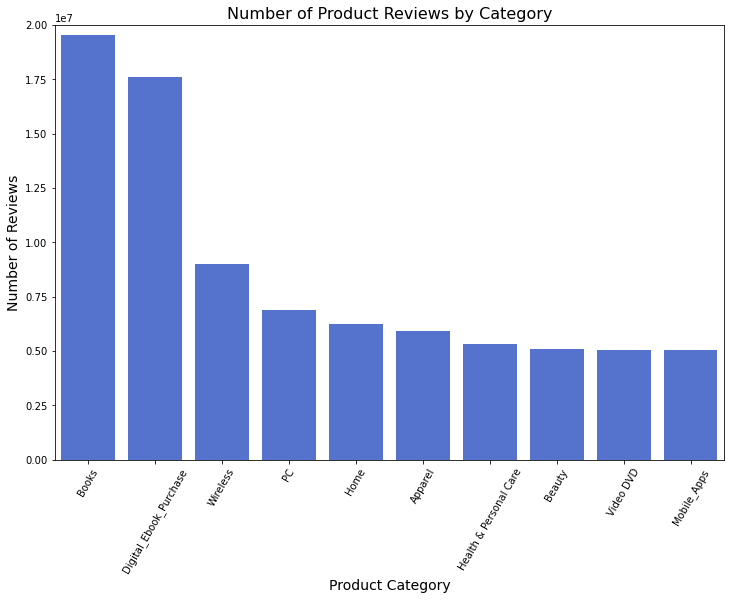

In [19]:
plt.figure(figsize=(12,8))
plt.title("Number of Product Reviews by Category", fontsize=16)
plt.xticks(rotation=60)
plt.ylim(0, 20000000)

sns.barplot(x="product_category",
            y="num_reviews",
            data=top_categories_df_pd.loc[:9, :],
            orient="v",
            color="royalblue")

plt.xlabel("Product Category", fontsize=14)
plt.ylabel("Number of Reviews", fontsize=14)

Books (both in print and digital format) are by far the most reviewed product category, with each of these categories having approximately double the number of reviews as the next largest category, Wireless. Kind of cool, considering Amazon started off as an online bookseller. 

### Question 2 
<br>
For this question, we want to determine which product category gets the highest and lowest star rating. Like we did in the previous question, we can group the reviews by category, and compute the mean star ratings.

In [13]:
# check if null values are present in the star_rating column
reviews_subset_df.filter((reviews_subset_df.star_rating.isNull())).count()

0

We group the records we cached in Question 1 by product category again, and then compute the mean star_rating. Round the values to two decimal places.

In [14]:
star_ratings_by_category = reviews_subset_df.\
groupby("product_category").\
agg(mean('star_rating').alias('avg_star_rating'))

star_ratings_by_category = star_ratings_by_category\
.withColumn("avg_star_rating", round(star_ratings_by_category["avg_star_rating"], 2))

In [15]:
star_ratings_df = star_ratings_by_category.orderBy("avg_star_rating", ascending=False)

star_ratings_df.limit(10)

product_category,avg_star_rating
Gift Card,4.73
Digital_Music_Pur...,4.64
Music,4.44
Books,4.34
Grocery,4.31
Digital_Ebook_Pur...,4.31
Video DVD,4.3
Tools,4.26
Automotive,4.25
Musical Instruments,4.25


In [16]:
# convert to Pandas df
star_ratings_pd = star_ratings_df.toPandas()

In [27]:
star_ratings_pd.shape

(43, 2)

In [22]:
star_ratings_pd.head(10)

,product_category,avg_star_rating
0,Gift Card,4.73
1,Digital_Music_Purchase,4.64
2,Music,4.44
3,Books,4.34
4,Grocery,4.31
5,Digital_Ebook_Purchase,4.31
6,Video DVD,4.30
7,Tools,4.26
8,Automotive,4.25
9,Musical Instruments,4.25


In [24]:
star_ratings_pd.tail(10)

,product_category,avg_star_rating
33,Electronics,4.04
34,Personal_Care_Appliances,3.98
35,Mobile_Apps,3.98
36,Home Entertainment,3.90
37,Wireless,3.89
38,Digital_Video_Games,3.85
39,Mobile_Electronics,3.76
40,Major Appliances,3.72
41,Software,3.57
42,Digital_Software,3.54


Text(0, 0.5, 'Average Star Rating')

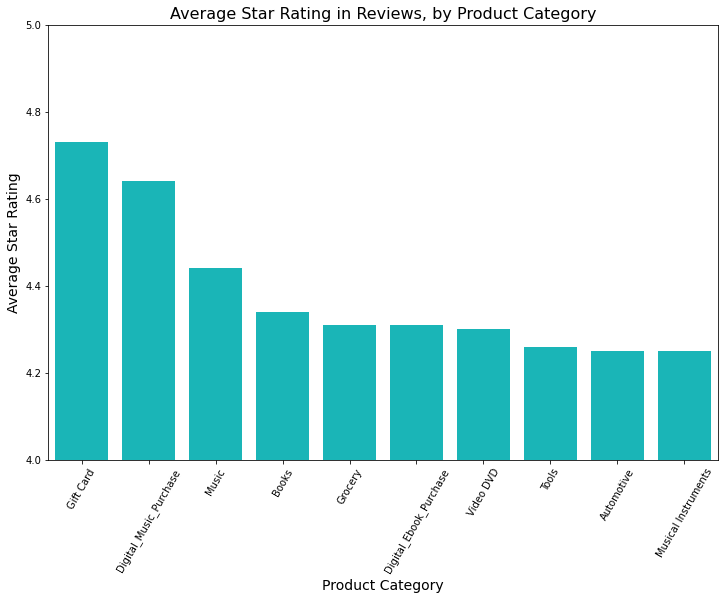

In [21]:
plt.figure(figsize=(12,8))
plt.title("Average Star Rating in Reviews, by Product Category", fontsize=16)
plt.xticks(rotation=60)
plt.ylim(4, 5)

sns.barplot(x="product_category",
            y="avg_star_rating",
            data=star_ratings_pd.loc[:9, :],
            orient="v",
            color="darkturquoise")

plt.xlabel("Product Category", fontsize=14)
plt.ylabel("Average Star Rating", fontsize=14)

Gift card is the product category with the highest average star rating (4.73). Each of the categories in the top 10 have an average star rating greater than 4. Five out of the top 10 are related to media (books, digital books, music, digital music, DVDs).
<br>
<br>
Software and digital software (unclear what differentiates these two categories) are the two lowest product categories with respect to average star rating. But even here, the rating is not that low (3.57 for the former and 3.54 for the latter). Only 0.75 "stars" separate these bottom two from the 10th highest product category.

### Question 3 
<br>
For this question, we want to determine whether there is any seasonal effect (annual) on the number of product reviews.

The review_date column is stored as a string, so we need to convert to a DateType format.

In [9]:
reviews_w_dates = reviews_subset_df.\
select(["review_id", "product_category", "review_date"]).\
withColumn('date', to_date(reviews_subset_df.review_date, format = "yyyy-MM-dd"))

In [10]:
reviews_w_dates.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- review_date: string (nullable = true)
 |-- date: date (nullable = true)



In [31]:
reviews_w_dates.limit(10)

review_id,product_category,review_date,date
RNRWRW58LZBJC,Home,2013-12-16,2013-12-16
R3MVIMMSBW93UC,Home,2013-12-16,2013-12-16
R3D710QBZ0OX1R,Home,2013-12-16,2013-12-16
R3391ZL3JZC0PA,Home,2013-12-16,2013-12-16
RJTQJ95Y4XANP,Home,2013-12-16,2013-12-16
R29VER3SO8AD0A,Home,2013-12-16,2013-12-16
RV5ULSDNJMSP1,Home,2013-12-16,2013-12-16
R3AMIERN69IGOP,Home,2013-12-16,2013-12-16
R2Q8JK1W9XD3QV,Home,2013-12-16,2013-12-16
R3PXSSHOQMKNDB,Home,2013-12-16,2013-12-16


Since we don't need the other columns we have in our cached data, we can release it. However, before we do any grouping according to category or date, it would make sense to select the  columns we need and cache that.

In [11]:
reviews_w_dates = reviews_w_dates.\
select(["review_id", "product_category", "date"])

reviews_subset_df.unpersist();

In [12]:
reviews_w_dates.cache()

review_id,product_category,date
R1KKOXHNI8MSXU,Apparel,2013-01-14
R26SP2OPDK4HT7,Apparel,2014-03-04
RWQEDYAX373I1,Apparel,2015-07-12
R231YI7R4GPF6J,Apparel,2015-06-03
R3KO3W45DD0L1K,Apparel,2015-06-12
R1C4QH63NFL5NJ,Apparel,2014-04-22
R2GP65O1U9N7BP,Apparel,2015-07-28
R3O29CT5MQQ3XQ,Apparel,2015-07-10
R1ZECD2AA8QFF6,Apparel,2015-08-09
R2S79GCF6J89OA,Apparel,2014-05-24


Separate year and month values from the full date value, so that we can group according to these and compute a count of reviews per category, per year, per month.

In [13]:
reviews_w_dates = reviews_w_dates.\
withColumn('month', month("date")).\
withColumn('year', year("date"))

reviews_w_dates.limit(5)

review_id,product_category,date,month,year
R2SXDSOZLHMQQW,Kitchen,2013-10-21,10,2013
R1GCT7I6K8TW0S,Kitchen,2013-10-21,10,2013
R26WEHPZEQPPFR,Kitchen,2013-10-21,10,2013
R21WQX9CJLCW0Y,Kitchen,2013-10-21,10,2013
R312S37XOQTMB1,Kitchen,2013-10-21,10,2013


In [14]:
reviews_by_category_and_date = reviews_w_dates.\
groupby('product_category', 'year', 'month').\
agg(count('review_id').alias('num_reviews')).\
orderBy('product_category', 'year', 'month')

reviews_by_category_and_date.limit(12)

product_category,year,month,num_reviews
Apparel,2000,9,1
Apparel,2000,10,4
Apparel,2000,11,1
Apparel,2001,10,4
Apparel,2001,12,1
Apparel,2002,1,8
Apparel,2002,2,20
Apparel,2002,3,2
Apparel,2002,4,1
Apparel,2002,5,1


Use the Arrow optimization to convert the PySpark DataFrame above to a pandas DataFrame. https://docs.databricks.com/spark/latest/spark-sql/spark-pandas.html

In [15]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

reviews_by_category_and_date_pd = reviews_by_category_and_date.toPandas()

In [16]:
reviews_by_category_and_date_pd.shape

(7593, 4)

In [17]:
print(reviews_by_category_and_date_pd['year'].max())
print(reviews_by_category_and_date_pd['year'].min())

2015
1995


In [46]:
reviews_by_category_and_date_pd[reviews_by_category_and_date_pd['product_category'] == 'Video Games']['year'].value_counts()

2006    12
2000    12
2013    12
2012    12
2011    12
2010    12
2009    12
2008    12
2007    12
2014    12
2005    12
2004    12
2003    12
2002    12
2001    12
2015     8
1999     7
1998     7
1997     2
Name: year, dtype: int64

We are working with a **20 year span of reviews**, and it's likely from some cursory visual inspection that **not all categories have reviews from each year, or each month within a given year**. So visualizing all of this will be difficult.

We can start by picking a year, maybe one of the more recent years, since it's possible that reviews will exist for categories in all months for this year. 

In [18]:
reviews_2015 = reviews_by_category_and_date_pd[reviews_by_category_and_date_pd['year'] == 2015]

reviews_2015.shape

(344, 4)

344 rows means that we don't have 12 months' worth of data for all 43 categories.

In [19]:
reviews_2014 = reviews_by_category_and_date_pd[reviews_by_category_and_date_pd['year'] == 2014]

In [20]:
reviews_2014.shape

(516, 4)

516 rows means that we have 12 months worth of data for all 43 product categories!

In [57]:
reviews_2014['month'].value_counts()

12    43
11    43
10    43
9     43
8     43
7     43
6     43
5     43
4     43
3     43
2     43
1     43
Name: month, dtype: int64

In [21]:
reviews_2014.reset_index(drop=True, inplace=True)

reviews_2014.head(10)

,product_category,year,month,num_reviews
0,Apparel,2014,1,136023
1,Apparel,2014,2,106562
2,Apparel,2014,3,125216
3,Apparel,2014,4,108049
4,Apparel,2014,5,109211
5,Apparel,2014,6,111738
6,Apparel,2014,7,184672
7,Apparel,2014,8,182097
8,Apparel,2014,9,201924
9,Apparel,2014,10,247549


In [37]:
categories = ['Digital_Ebook_Purchase', 'Books', 'Wireless', 'Apparel',
              'Home', 'PC', 'Health & Personal Care', 'Beauty',
              'Mobile_Apps', 'Digital_Video_Download', 'Shoes', 'Sports']

reviews_2014_subset = reviews_2014[reviews_2014['product_category'].isin(categories)]

In [38]:
reviews_2014_subset.shape

(144, 4)

In [22]:
reviews_2014_wide = reviews_2014.pivot(index='product_category', columns='month', values='num_reviews')
reviews_2014_wide.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
product_category,,,,,,,,,,,,
Apparel,136023,106562,125216,108049,109211,111738,184672,182097,201924,247549,262961,346359
Automotive,67778,57596,67677,64163,67120,71975,126882,133450,125668,129213,119847,143628
Baby,35434,28339,32727,29145,28498,29449,45004,47486,46374,47821,46651,59307
Beauty,110862,96530,108289,96470,95597,99278,158192,162422,154147,165882,163200,199918
Books,298346,248314,253392,224304,216873,218339,330355,333685,331385,335804,304856,376040


In [23]:
reviews_2014_wide['annual_total'] = reviews_2014_wide.sum(axis=1)

In [27]:
reviews_2014_wide_top = reviews_2014_wide.sort_values(by='annual_total', ascending=False).head(12)

In [35]:
reviews_2014_wide_top

month,1,2,3,4,5,6,7,8,9,10,11,12,annual_total
product_category,,,,,,,,,,,,,
Digital_Ebook_Purchase,550504,442524,523158,509022,513129,508211,623630,623598,537751,606597,564273,612619,6615016
Books,298346,248314,253392,224304,216873,218339,330355,333685,331385,335804,304856,376040,3471693
Wireless,206548,164691,175017,156760,151356,160964,276025,288900,280614,308103,294339,367054,2830371
Apparel,136023,106562,125216,108049,109211,111738,184672,182097,201924,247549,262961,346359,2122361
Home,168070,125526,129186,110182,107697,111732,179138,188421,184780,196064,204977,293517,1999290
PC,192505,141366,140257,119098,112672,112501,181457,189732,183078,185483,181381,257740,1997270
Health & Personal Care,110658,101610,112441,101965,100526,104871,163094,171154,165158,175835,170306,204641,1682259
Beauty,110862,96530,108289,96470,95597,99278,158192,162422,154147,165882,163200,199918,1610787
Mobile_Apps,163373,139244,129657,104992,95049,103365,137233,129043,123654,145026,155808,182643,1609087


I tried to feed the wide format dataframe directly into the sns.lineplot() function, per this [documention](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot), but it didn't really work out. I want month on the x axis, not as a color differentiator.

<AxesSubplot:xlabel='product_category'>

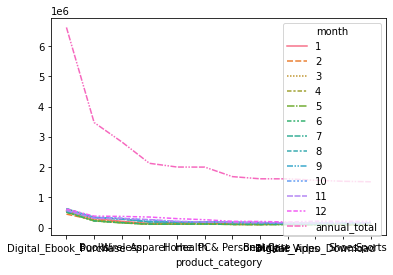

In [42]:
sns.lineplot(data=reviews_2014_wide_top)

Text(0, 0.5, 'Number of Reviews')

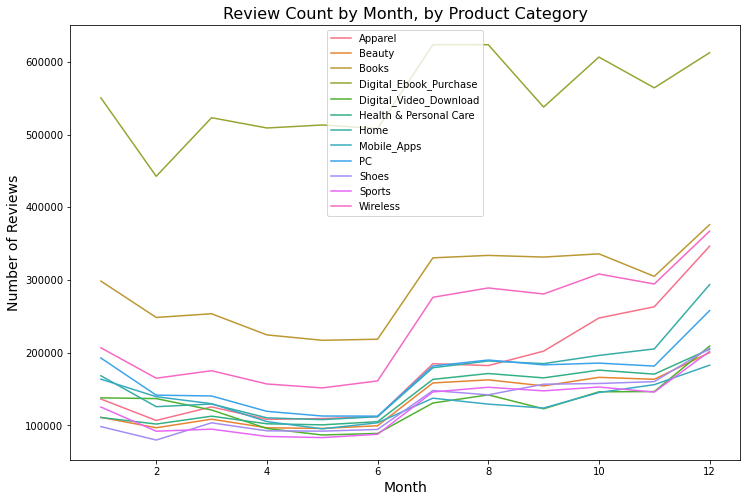

In [40]:
plt.figure(figsize=(12,8))
plt.title("Review Count by Month, by Product Category", fontsize=16)
#plt.xticks(rotation=60)

sns.lineplot(x="month",
            y="num_reviews",
            hue="product_category",
            data=reviews_2014_subset)

plt.legend(loc='best')
plt.xlabel("Month", fontsize=14)
plt.ylabel("Number of Reviews", fontsize=14)

I selected the top 12 product categories according to total number of reviews for the year 2014. I did this because including all 43 categories in the chart made it very hard to distinguish which line belonged to which category, and the legend was huge. 
<br>
<br>
Digital E-Books and print Books are the top 2 categories for this year.
<br>
<br>
We can observe the following general pattern for most categories. Gradually decreasing trend for the first halg of the year, followed by an increase in the period between June and July, fairly consistent level throughtout remaining summer and autumn months, following by sharp uptick in last months of the year.

### Question 4
<br>
For this question, we want to examine the helpfulness of the product reviews. We can define helpfulness as the ratio of the helpful votes to total votes given to a review. We also want to look correlation between helpfulness and the length of the review headline and/or review body.

In [44]:
reviews_w_dates.unpersist();

In [58]:
reviews_subset = reviews_df.\
withColumn('helpfulness', round(reviews_df.helpful_votes / reviews_df.total_votes, 2)).\
withColumn('review_headline_word_ct', size(split(col('review_headline'), ' '))).\
withColumn('review_body_word_ct', size(split(col('review_body'), ' '))).\
select('customer_id', 'product_id', 'review_id', 'product_title', 'helpful_votes', 'total_votes', 'helpfulness', 'review_headline', 'review_headline_word_ct','review_body', 'review_body_word_ct')

In [57]:
reviews_subset.unpersist();

In [59]:
reviews_subset.cache()

customer_id,product_id,review_id,product_title,helpful_votes,total_votes,helpfulness,review_headline,review_headline_word_ct,review_body,review_body_word_ct
32158956,B01KL6O72Y,R1KKOXHNI8MSXU,Easy Tool Stainle...,0,0,null,★ THESE REALLY DO...,10,These Really Do W...,573
2714559,B01ID3ZS5W,R26SP2OPDK4HT7,V28 Women Cowl Ne...,1,2,0.5,Favorite for wint...,5,I love this dress...,70
12608825,B01I497BGY,RWQEDYAX373I1,James Fiallo Men'...,0,0,null,Great Socks for t...,5,"Nice socks, great...",15
25482800,B01HDXFZK6,R231YI7R4GPF6J,Belfry Gangster 1...,0,0,null,Slick hat!,2,I bought this for...,31
9310286,B01G6MBEBY,R3KO3W45DD0L1K,JAEDEN Women's Be...,0,0,null,I would do it again!,5,Perfect dress and...,8
26631939,B01FWRXN0Y,R1C4QH63NFL5NJ,Levi's Boys' 514 ...,0,0,null,Five Stars,2,Excellent for my ...,10
48785098,B01EXNH1HE,R2GP65O1U9N7BP,Minimalist Wallet...,0,0,null,Love it!,2,Raw is the only w...,19
39548589,B01E7OL09O,R3O29CT5MQQ3XQ,Harriton Men's Ba...,0,0,null,Three Stars,2,A bit large.,3
29355866,B01DXHX81O,R1ZECD2AA8QFF6,Jockey Women's Un...,0,0,null,Five Stars,2,Great fit!,2
27477484,B01DDULIJK,R2S79GCF6J89OA,Alexander Del Ros...,0,0,null,Not my favorite.,3,Shirt a bit too l...,38


**Top 10 reviews in terms of number of helpful votes.**

In [ ]:
reviews_subset.select(['review_id', 'product_title', 'helpful_votes', 'total_votes', 'helpfulness']).orderBy('helpful_votes', ascending=False).limit(10)

review_id,product_title,helpful_votes,total_votes,helpfulness
R3R24QH3CDS83N,Kindle: Amazon's ...,47524,48362,0.98
R19XO9PS38WRWO,BIC Cristal For H...,41393,41866,0.99
R2XKMDXZHQ26YX,The Mountain Kids...,41278,41889,0.99
R2YVZNKUMWGYJ4,Kindle Keyboard 3...,31924,32373,0.99
R1PL1U31XQG8KG,"Kindle Fire HD 7""...",31417,32166,0.98
RBUNL9QWDYTD7,Kindle Fire (Prev...,28611,29433,0.97
R2JF7E91JJVHAT,Fifty Shades of G...,27550,28727,0.96
R3PG4OX6C5KVN4,Wheelmate Laptop ...,26132,26382,0.99
RV0R3AODMRNJZ,Kindle Wireless R...,24714,26143,0.95
RXXPVOUH9NLL3,Tuscan Dairy Whol...,23755,24170,0.98


**Top 10 reviews in terms of number of total votes.**

In [61]:
reviews_subset.select(['review_id', 'product_title', 'helpful_votes', 'total_votes', 'helpfulness']).orderBy('total_votes', ascending=False).limit(10)

review_id,product_title,helpful_votes,total_votes,helpfulness
R3R24QH3CDS83N,Kindle: Amazon's ...,47524,48362,0.98
R2XKMDXZHQ26YX,The Mountain Kids...,41278,41889,0.99
R19XO9PS38WRWO,BIC Cristal For H...,41393,41866,0.99
R2YVZNKUMWGYJ4,Kindle Keyboard 3...,31924,32373,0.99
R1PL1U31XQG8KG,"Kindle Fire HD 7""...",31417,32166,0.98
RBUNL9QWDYTD7,Kindle Fire (Prev...,28611,29433,0.97
R2JF7E91JJVHAT,Fifty Shades of G...,27550,28727,0.96
R3PG4OX6C5KVN4,Wheelmate Laptop ...,26132,26382,0.99
RV0R3AODMRNJZ,Kindle Wireless R...,24714,26143,0.95
RXXPVOUH9NLL3,Tuscan Dairy Whol...,23755,24170,0.98


The two lists above indicate that these reviews are also very helpful, because they all have greater than 95% helpful votes.

**Correlation analysis between helpfulness and word count.**

In [63]:
reviews_subset_no_nulls = reviews_subset.\
filter(reviews_subset.helpfulness.isNotNull()).\
select(['helpful_votes', 'total_votes', 'helpfulness', 'review_headline_word_ct', 'review_body_word_ct'])

In [64]:
reviews_subset.unpersist();

In [65]:
reviews_subset_no_nulls.cache()

helpful_votes,total_votes,helpfulness,review_headline_word_ct,review_body_word_ct
1,2,0.5,5,70
6,7,0.86,2,71
3,5,0.6,3,164
3,4,0.75,2,10
1,1,1.0,6,199
1,1,1.0,2,6
1,1,1.0,1,38
2,3,0.67,2,12
1,2,0.5,2,11
1,1,1.0,10,53


For the correlation between word length and helpfulness, I consulted the this [StackOverflow post](https://stackoverflow.com/questions/52214404/how-to-get-the-correlation-matrix-of-a-pyspark-data-frame) which suggested using the Correlation function from pyspark.ml.stat module.

In [66]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [67]:
# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=reviews_subset_no_nulls.columns, outputCol=vector_col)
df_vector = assembler.transform(reviews_subset_no_nulls).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

In [69]:
matrix.collect()[0]["pearson({})".format(vector_col)].values

array([1.        , 0.98460412, 0.06578821, 0.02054965, 0.12789176,
       0.98460412, 1.        , 0.02384571, 0.02045696, 0.13097519,
       0.06578821, 0.02384571, 1.        , 0.04768109, 0.11659838,
       0.02054965, 0.02045696, 0.04768109, 1.        , 0.14198094,
       0.12789176, 0.13097519, 0.11659838, 0.14198094, 1.        ])

column order: helpful_votes,total_votes,helpfulness,review_headline_word_ct,review_body_word_ct
                       1        2           3             4                       5 

Unsurprisingly, the number of helpful votes is strongly correlated with the number of total votes. Beyond this, however, the Pearson correlations are very low.
<br>
<br>
If we look at rows 4 and 5 of the matrix, and the first 3 columns, we see that the correlations of vote tally and helpfulness metric with word count in the review headline is very low. In row 5, we see slightly higher correlation, but not larger than 0.13.
<br>
<br>
The word count of review headline also does not appear to be strongly correlated with word count of review body. 

**Correlation between number of reviews per customer and helpfulness.**

In [70]:
reviews_subset_no_nulls.unpersist();

Let's restrict our consideration to only reviews where helpfulness score is not null and total votes is greater than 0.

In [72]:
reviews_by_customer.unpersist();

In [73]:
reviews_by_customer = reviews_subset.\
filter(reviews_subset.helpfulness.isNotNull() & (reviews_subset.total_votes > 0) ).\
select(['customer_id', 'review_id', 'helpful_votes', 'total_votes', 'helpfulness'])

reviews_by_customer.cache()

customer_id,review_id,helpful_votes,total_votes,helpfulness
2714559,R26SP2OPDK4HT7,1,2,0.5
30225894,R738LCNRSJVXP,6,7,0.86
48401445,R23AXPXH0CUCTZ,3,5,0.6
502031,R3DYA1XAAIV459,3,4,0.75
10927125,R3J8AIC44NREJW,1,1,1.0
13414752,ROF5PF9IKYOHJ,1,1,1.0
3348867,R1POXQDVEQ2KF2,1,1,1.0
10012042,R1H977N2YSYWU5,2,3,0.67
6291789,R33HFP9HM76ARW,1,2,0.5
5836158,RIIIRR460TAO4,1,1,1.0


In [77]:
reviews_by_customer_grouped = reviews_by_customer.\
groupby('customer_id').\
agg(count('review_id').alias('num_reviews'),
    mean('helpful_votes').alias('avg_helpful_votes'),
    mean('total_votes').alias('avg_total_votes'),
    mean('helpfulness').alias('avg_helpfulness')).\
orderBy('num_reviews', ascending=False)

In [78]:
reviews_by_customer_grouped.limit(5)

customer_id,num_reviews,avg_helpful_votes,avg_total_votes,avg_helpfulness
50122160,48834,5.319408608756194,6.382151779497891,0.826927345701765
50732546,27923,4.364359130465924,5.807900297245998,0.738731869784765
52496677,14102,6.6404765281520355,7.555524039143384,0.8851737342220961
18116317,8591,3.243161448027005,3.514142707484577,0.9439809102549178
50736950,7506,2.694111377564615,5.670263788968825,0.5768824940047965


Who has time to leave 50,000 product reviews?
Anyway, repeat correlation matrix computation.

In [79]:
reviews_df_corr = reviews_by_customer_grouped.select(['num_reviews', 'avg_helpful_votes', 'avg_total_votes', 'avg_helpfulness'])

In [80]:
# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=reviews_df_corr.columns, outputCol=vector_col)
df_vector = assembler.transform(reviews_df_corr).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

In [84]:
matrix.collect()[0]["pearson({})".format(vector_col)].values

array([1.        , 0.00480009, 0.00393345, 0.01046357, 0.00480009,
       1.        , 0.97402148, 0.08097476, 0.00393345, 0.97402148,
       1.        , 0.02268946, 0.01046357, 0.08097476, 0.02268946,
       1.        ])

For some reason the correlation matrix output is different than it was in previous use. However, there appears to be low values across the matrix. My assumption is that the 0.97 value is for correlation between average number of helpful votes and average number of total votes across all reviews for given customer. **No evident correlation between number of reviews and helpfulness.**